<a href="https://colab.research.google.com/github/moch1996/Vaycold/blob/main/Recommend_Algorithm/%EA%B0%84%EB%8B%A8%ED%95%9C%20%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 간단한 추천시스템 만들기
  - ### 목표 : 특정유저가 특정영화에 몇점을 주었는가??
  - 간단한 추천알고리즘 만들기
  - 평점을 예측하고 RMSE로 평가

## 라이브러리 정의

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.listdir('drive/MyDrive/fastcampus/recommend/movielens')

['ratings.csv', 'tags.csv', 'movies.csv', 'README.txt', 'links.csv']

In [6]:
path = '/content/drive/MyDrive/fastcampus/recommend/movielens'

In [7]:
# 데이터 불러오기

ratings_df = pd.read_csv(os.path.join(path,'ratings.csv'), encoding='utf-8')
movies_df = pd.read_csv(os.path.join(path,'movies.csv'), index_col = 'movieId', encoding='utf-8')
tags_df = pd.read_csv(os.path.join(path,'tags.csv'), encoding='utf-8')

In [8]:
print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


## 데이터 탐색

In [9]:
# Ratings data를 주로 확인할 계획

In [10]:
# 몇 명의 유저가 몇 개의 영화에 평점을 주었는 지 확인해보자
num_users = len(ratings_df.userId.unique())
print('총 유저 수 : ',num_users,'명')

num_movies = len(ratings_df.movieId.unique())
print('총 영화 수 : ',num_movies,'편')


총 유저 수 :  610 명
총 영화 수 :  9724 편


In [11]:
# 각 유저가 어떤 영화에 평점을 몇점 주었는지 확인해보자
# 피벗테이블을 이용하자

user_movie_matrix = ratings_df.pivot(
    index = 'movieId',
    columns = 'userId',
    values = 'rating',
  ).fillna(0) #결측값은 0으로 두자

In [12]:
user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# sparse matrix로 옮겨서 확인해보자
sparse_mat = csr_matrix(user_movie_matrix.values)
print(sparse_mat) # 점수가 있는 것만 출력하는 매트릭스

  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (9700, 337)	2.5
  (9701, 337)	3.0
  (9702, 183)	4.0
  (9702, 247)	3.5
  (9703, 317)	2.5
  (9704, 209)	1.0
  (9705, 461)	2.5
  (9706, 49)	3.5
  (9707, 337)	1.5
  (9708, 337)	4.0
  (9709, 337)	1.0
  (9710, 337)	1.5
  (9711, 337)	1.0
  (9712, 337)	1.0
  (9713, 183)	4.5
  (9714, 183)	3.5
  (9715, 183)	3.0
  (9716, 183)	4.0
  (9717, 183)	4.0
  (9718, 183)	3.5
  (9719, 183)	4.0
  (9720, 183)	3.5
  (9721, 183)	3.5
  (9722, 183)	3.5
  (9723, 330)	4.0


In [14]:
user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# 각 유저가 평점을 내린 영화는 몇개인지 확인해보자
# - list( value_counts)를 했을 때는 인덱싱 값 제외하고 내림차순으로 list형식으로 반환된다!! 참고!!
# - List comprehension을 사용하자!
# - value_counts()를 사용하면 내림차순으로 결과가 나온다. 이를 이용하여 0이 가장 많을테니 [1:]로 인덱싱하여 0을 제거한 수를 알아 낼 수 있다.

In [16]:
user_info_df = pd.DataFrame(
    data = [
            sum(list(user_movie_matrix[int(x)].value_counts())[1:]) for x in user_movie_matrix.columns
    ],
    index = user_movie_matrix.columns,
    columns = ['movie_rated']
)
user_info_df

,movie_rated
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


In [17]:
# 같은 방식으로 각 영화는 몇 번씩 선택받았는지 확인해보자
# 그 행의 모든 값들을 가져와야 되므로 df.loc[]를 사용하자

In [18]:
user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
movie_info_df = pd.DataFrame(
    data = [
            sum(list(user_movie_matrix.loc[int(x)].value_counts())[1:]) for x in user_movie_matrix.index
    ],
    index = user_movie_matrix.index,
    columns = ['users_rated']
)
movie_info_df

,users_rated
movieId,
1,215
2,110
3,52
4,7
5,49
...,...
193581,1
193583,1
193585,1


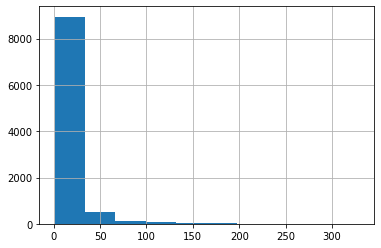

In [20]:
movie_info_df.users_rated.sort_values(ascending=False).hist()

# 데이터가 편향되있다. 즉 대부분의 영화들이 평점이 하나만 가지고 있다고 봐도 무방하다. 

## Training Set & Test set

In [21]:
train_df, test_df = train_test_split(ratings_df, test_size = 0.2 ,random_state = 1234)

In [22]:
print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [23]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [24]:
train_df.head(5)

,userId,movieId,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


In [25]:
test_df.head(5)

,userId,movieId,rating,timestamp
99731,610,3527,5.0,1479545223
97583,606,1250,3.5,1171376891
38197,262,213,5.0,840310907
11474,68,69406,3.0,1261622505
34105,232,4728,3.0,1218166950


In [26]:
# 여기서 생각해봐야 할 점
# - 단순히 랜덤하게 나눈다고 했을 때 트레이닝 셋에는 1번 유저가 있지만 테스트 셋에는 1번 유저가 없을 수 도 있는 상황이 만들어 질 수 있음.

In [27]:
# test 셋에는 존재하지만 training 셋에는 없는 영화 또는 사용자 비율을 알아보자

# - userId

In [28]:
test_df['userId'].unique() # test셋의 userid 고유한 수를 보여줌

array([610, 606, 262,  68, 232,  29, 177, 601, 528,  28, 156, 105, 198,
       298, 217, 580, 496,  52, 312, 372, 590, 462, 307, 514, 596, 477,
       339,  91, 525, 414, 140, 142, 292, 234, 325, 489, 483, 288, 411,
        14, 266, 594, 500, 381, 267, 599, 221, 201, 317, 534,  89, 274,
       196, 182, 239,  82, 515, 284, 209, 111,  35, 322, 167, 571, 416,
       306, 474,  36, 600, 287, 482, 448, 480, 573, 319, 347, 219, 212,
        62, 237, 252, 305, 310, 357, 131, 567, 200, 376, 260, 301, 371,
       303,  88, 199, 275,  50, 434, 432, 469, 390, 460, 522, 562, 311,
       568, 417, 493, 387, 524, 113, 103, 598,  64,   9, 560,   7, 415,
       122, 501,   1, 153, 542, 314, 245, 552,  19, 586, 368,  18, 541,
       380, 438, 370, 279, 139,  66, 315, 479, 593, 313, 608, 202, 447,
        44, 296, 517, 452,  51, 428, 597, 265,  85, 101,  96, 195, 356,
        98, 318, 226, 304, 362,  33, 497,  46, 332, 186, 509, 110,  42,
        24,  84, 425,  23, 587, 561, 409, 192, 369, 136, 352, 55

In [29]:
set(test_df['userId'].unique()) # 그 고유한 것을 set을 통해 하나의 배열??세트??로 만들어줌

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [30]:
# 트레이닝 셋도 똑같이 한 후 테스트 셋에서 빼줌
set(test_df['userId'].unique()) - set(train_df['userId'].unique())


set()

In [31]:
# 뭐여 다 있네 순간 오류난 줄
list(set(test_df['userId'].unique()) - set(train_df['userId'].unique()))

[]

In [32]:
len(list(set(test_df['userId'].unique()) - set(train_df['userId'].unique())))

0

In [33]:
print('사용자 : ',len(list(set(test_df['userId'].unique()) - set(train_df['userId'].unique()))))

사용자 :  0


In [34]:
# 영화도 해보자
test_df.movieId.unique()

array([3527, 1250,  213, ..., 5268, 3925, 2328])

In [35]:
train_df.movieId.unique()

array([ 5943,  2571,  8958, ..., 26861,  6814,  6279])

In [36]:
set(test_df.movieId.unique())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 131098,
 27,
 28,
 29,
 26,
 31,
 32,
 32799,
 34,
 36,
 38,
 39,
 40,
 41,
 42,
 65577,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 65585,
 52,
 53,
 54,
 65588,
 58,
 60,
 61,
 62,
 65596,
 63,
 65,
 65601,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 79,
 81,
 82,
 85,
 86,
 87,
 88,
 89,
 92,
 93,
 94,
 95,
 97,
 100,
 101,
 102,
 103,
 104,
 105,
 107,
 110,
 111,
 112,
 113,
 116,
 117,
 118,
 119,
 121,
 122,
 123,
 125,
 132,
 135,
 137,
 140,
 141,
 145,
 146,
 147,
 65685,
 150,
 151,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 168,
 169,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 183,
 185,
 186,
 98491,
 188,
 190,
 191,
 193,
 194,
 195,
 196,
 198,
 199,
 65738,
 203,
 204,
 205,
 207,
 208,
 211,
 212,
 213,
 215,
 216,
 217,
 218,
 222,
 223,
 224,
 225,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 

In [37]:
set(train_df.movieId.unique())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 131104,
 34,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 65585,
 50,
 52,
 53,
 54,
 55,
 98361,
 58,
 57,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 131130,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 163925,
 86,
 88,
 89,
 87,
 92,
 93,
 94,
 95,
 65631,
 97,
 96,
 99,
 100,
 101,
 32862,
 6533,
 104,
 105,
 65642,
 107,
 32875,
 108,
 110,
 111,
 112,
 113,
 106,
 65651,
 116,
 118,
 119,
 121,
 122,
 123,
 32892,
 125,
 126,
 128,
 129,
 32898,
 132,
 135,
 32906,
 140,
 141,
 163981,
 144,
 145,
 65682,
 147,
 148,
 65685,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 131237,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 180,
 181,
 183,
 184,
 185,
 186,
 98491,
 188,
 187,
 190,
 191,
 189,
 193,
 194

In [38]:
len(list(set(test_df.movieId.unique())-set(train_df.movieId.unique())))

# 얜 쫌 많다..

786

In [39]:
print('영화 : ',len(list(set(test_df.movieId.unique())-set(train_df.movieId.unique())))
)

print('테스트 셋의 영화 수 : ', len(test_df.movieId.unique()) )

영화 :  786
테스트 셋의 영화 수 :  5171


In [40]:
# 그렇다면 포함이 안된 영화는 어떤 것들인지 보자

movies_not_included = list(set(test_df.movieId.unique())- set(train_df.movieId.unique()))

In [41]:
print(sorted(movies_not_included[:10]))

[6145, 26645, 75803, 79897, 83969, 88069, 110603, 122888, 131098, 182299]


In [42]:
not_included_df = test_df[test_df.movieId.isin(movies_not_included)].sort_values(by='movieId')
not_included_df

,userId,movieId,rating,timestamp
29386,202,49,3.0,974925453
97066,604,117,3.0,832080636
99501,609,137,3.0,847221054
27959,191,178,1.0,829760898
98493,607,241,4.0,964744490
...,...,...,...,...
49862,318,189381,2.5,1536097988
71998,462,189713,2.5,1536467299
52008,338,190221,1.0,1530148473
27257,184,193583,3.5,1537109545


## 간단한 추천 알고리즘 만들기

In [43]:
test_df.head()

,userId,movieId,rating,timestamp
99731,610,3527,5.0,1479545223
97583,606,1250,3.5,1171376891
38197,262,213,5.0,840310907
11474,68,69406,3.0,1261622505
34105,232,4728,3.0,1218166950


### 랜덤으로 평점 예측하기

In [44]:
# 평점의 범위
ratings_range = np.arange(0.5,5.5,0.5)
ratings_range 

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [45]:
import random
pred_random = [random.choice(ratings_range) for x in range(len(test_df))]
pred_random[:10]

[0.5, 3.5, 3.5, 2.0, 5.0, 5.0, 1.0, 2.5, 5.0, 4.0]

In [46]:
test_df['pred_ratings_random'] = pred_random
test_df.head()

,userId,movieId,rating,timestamp,pred_ratings_random
99731,610,3527,5.0,1479545223,0.5
97583,606,1250,3.5,1171376891,3.5
38197,262,213,5.0,840310907,3.5
11474,68,69406,3.0,1261622505,2.0
34105,232,4728,3.0,1218166950,5.0


In [47]:
test_df.drop('timestamp', axis=1, inplace=True)

In [48]:
test_df.head()

,userId,movieId,rating,pred_ratings_random
99731,610,3527,5.0,0.5
97583,606,1250,3.5,3.5
38197,262,213,5.0,3.5
11474,68,69406,3.0,2.0
34105,232,4728,3.0,5.0


In [49]:
rmse = sqrt(mean_squared_error(test_df.rating.values, test_df.pred_ratings_random.values))
print(rmse)

# 예측 개똥망임 ㄹㅇㅇ

1.9202154282157082


### 영화 평균 평점기반 예측하기
  1. 트레이닝 셋의 모든 영화에 대해서 평균 평점 구하기
  2. 테스트 셋을 예측할 때 트레인 셋의 영화 평균 평점을 활용, 만약 없을 경우 random으로 선택

In [50]:
train_df.head()

,userId,movieId,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


In [51]:
train_movie_df = train_df.groupby('movieId').mean()
train_movie_df.head()

,userId,rating,timestamp
movieId,,,
1,307.473373,3.893491,1.128439e+09
2,327.475610,3.396341,1.142893e+09
3,266.386364,3.454545,9.900434e+08
4,192.750000,2.250000,8.425133e+08
5,309.526316,3.039474,1.007415e+09


In [52]:
# 함수를 구현하자
# 새로 만든 df의 무비id가 테스트id에 있을 경우 새로만든 df의 rating 값을 예측점수로 활용한다
# 없을 경우 랜덤초이스로 고른다.

def avg(training_set, x) :
  if x in training_set.index :
    pred_rating = training_set.loc[x]['rating']
  else :
    pred_rating = random.choice(ratings_range)
  return pred_rating

In [53]:
test_df.head()

,userId,movieId,rating,pred_ratings_random
99731,610,3527,5.0,0.5
97583,606,1250,3.5,3.5
38197,262,213,5.0,3.5
11474,68,69406,3.0,2.0
34105,232,4728,3.0,5.0


In [54]:
test_df['pred_rating_movie'] = test_df['movieId'].apply(lambda x : avg(train_movie_df,x))
test_df.head()

,userId,movieId,rating,pred_ratings_random,pred_rating_movie
99731,610,3527,5.0,0.5,3.604167
97583,606,1250,3.5,3.5,4.180556
38197,262,213,5.0,3.5,3.750000
11474,68,69406,3.0,2.0,3.571429
34105,232,4728,3.0,5.0,2.769231


In [55]:
rmse = sqrt(mean_squared_error(test_df.rating.values, test_df.pred_rating_movie.values))
print(rmse)

1.0283480536895675


### 사용자 평균 평점기반 예측하기

1. train set의 모든 유저가 준 평균 평점
2. test set 예측할 때, 유저가 train set에서 준 평균 평점을 활용. 유저가 없을 경우 random 평점 적용

In [56]:
train_user_df = train_df.groupby('userId').mean()

print(train_user_df.shape)
print(train_user_df.head())

(610, 3)
             movieId    rating     timestamp
userId                                      
1        1891.168478  4.320652  9.649865e+08
2       70402.760000  3.940000  1.445715e+09
3        8394.733333  2.516667  1.306464e+09
4        1957.923077  3.631868  9.655941e+08
5         337.606061  3.636364  8.474351e+08


In [57]:
test_df['pred_rating_user'] = test_df['userId'].apply(lambda x: avg(train_user_df, x))

test_df.head()

,userId,movieId,rating,pred_ratings_random,pred_rating_movie,pred_rating_user
99731,610,3527,5.0,0.5,3.604167,3.678709
97583,606,1250,3.5,3.5,4.180556,3.649718
38197,262,213,5.0,3.5,3.750000,2.925000
11474,68,69406,3.0,2.0,3.571429,3.229331
34105,232,4728,3.0,5.0,2.769231,3.242268


In [58]:
mse = mean_squared_error(y_true=test_df['rating'].values, y_pred=test_df['pred_rating_user'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

# 성능이 좋아졌음
# 사람 기반으로 모델링을 하는 것이 효율이 더 좋게 나오는 것 같다.

0.8905889036428333 0.9437101798978504


### Rule 기반 영화 평점 예측하기

1. train set에 포함된 유저의 영화 평균 평점과 영화의 장르를 활용하여, 장르별 평균 평점 계산 -> test set의 영화 장르의 평균 평점으로 예측

In [59]:
# create user_movie matrix by only using train_df
train_user_movie_matrix = train_df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [60]:
train_user_movie_matrix

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,4.0,0.0,4.0,3.0,4.0,2.5,0.0,2.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
genres_df = movies_df['genres'].str.get_dummies(sep='|')
print(genres_df.shape)
genres_df = genres_df.loc[train_df.movieId.unique()]
print(genres_df.shape)
genres_df.head()

(9742, 20)
(8938, 20)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
5943,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2571,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
8958,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2322,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2959,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0


In [62]:
# train set에서 영화별 유저 평점 평균
train_user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,4.0,0.0,4.0,3.0,4.0,2.5,0.0,2.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
train_movie_avg_ratings_df = train_user_movie_matrix.copy()
train_movie_avg_ratings_df = train_movie_avg_ratings_df.replace(0, np.NaN)
train_movie_avg_ratings_df = train_movie_avg_ratings_df.mean(axis=1)
train_movie_avg_ratings_df.head()

movieId
1    3.893491
2    3.396341
3    3.454545
4    2.250000
5    3.039474
dtype: float64

In [64]:
# genres_df에서 해당 장르가 포함된 모든 영화 index를 가져와서, 해당 영화의 유저 평균 평점의 평균을 구한다
# 그 후 장르 평균 평점으로 활용한다

genres_avg_ratings_df = pd.DataFrame(
    data = None,
    index = genres_df.columns,
    columns = ['avg_ratings']
)

genres_avg_ratings_df

,avg_ratings
(no genres listed),NaN
Action,NaN
Adventure,NaN
Animation,NaN
Children,NaN
Comedy,NaN
Crime,NaN
Documentary,NaN
Drama,NaN
Fantasy,NaN


In [65]:
# 코드 하나하나 분해해서 확인해보자. 
# Action 영화를 예로 들어보자
genres_df['Action'] #이렇게 실행했을 경우 get_dummies를 이용하였기 때문에 action인 영화는 1로 표시가 된다.
genres_df['Action'].isin([1]) # Action이냐? 라는 의미는 1이냐? 했을 때 True값인 영화만 긁어오면 되는 것과 같은 의미가 된다.
genres_df[genres_df['Action'].isin([1])] # 이제 genres_df에서 저 조건에 True값인 애들만 가져오게 됨, 즉 action 영화가 1인 것들만 가져오게됨
genres_df[genres_df['Action'].isin([1])].index # 이 식의 인덱스 값은 action 영화에 해당되는 영화들의 id임
train_movie_avg_ratings_df.loc[genres_df[genres_df['Action'].isin([1])].index] # 영화평균평점 무비에서 genres_df에 해당되는 영화를 찾는 식임. 즉 다시 말하면 액션영화들의 평균평점이 나옴
train_movie_avg_ratings_df.loc[genres_df[genres_df['Action'].isin([1])].index].mean() # 이 값들의 다시 평균을 구한다 즉 action 영화는 평균평점이 3.11점이라는 의미
# 이제 이 나온 값을 기존에 만들었던 데이터 프레임에 넣는 알고리즘

3.1108503839097223

In [66]:
for genre in genres_df.columns :
  mean_ = train_movie_avg_ratings_df.loc[genres_df[genres_df[genre].isin([1])].index].mean()
  genres_avg_ratings_df.loc[genre]['avg_ratings'] = mean_


genres_avg_ratings_df

,avg_ratings
(no genres listed),3.33642
Action,3.11085
Adventure,3.23072
Animation,3.49226
Children,3.10123
Comedy,3.18148
Crime,3.31359
Documentary,3.80103
Drama,3.42909
Fantasy,3.24026


In [67]:
# 이제 각 영화가 가진 장르의 평균 평점을 가지고 평점을 예측해보자
# 예를 들어서 한 영화의 장르가 thriller, war, western이라면 3,1733,3.57132, 3.39769의 평균을 구해서 도출해 낸다.

In [76]:
def get_genre_avg_ratings(x) :
  genres_list = movies_df.loc[x]['genres'].split('|')
  rating = 0
  for genre in genres_list :
    rating += genres_avg_ratings_df.loc[genre]['avg_ratings']

  return rating/len(genres_list)


In [77]:
test_df

,userId,movieId,rating,pred_ratings_random,pred_rating_movie,pred_rating_user
99731,610,3527,5.0,0.5,3.604167,3.678709
97583,606,1250,3.5,3.5,4.180556,3.649718
38197,262,213,5.0,3.5,3.750000,2.925000
11474,68,69406,3.0,2.0,3.571429,3.229331
34105,232,4728,3.0,5.0,2.769231,3.242268
...,...,...,...,...,...,...
41080,279,593,4.0,1.5,4.127907,3.666667
4897,31,780,4.0,4.0,3.470760,3.911765
8023,56,410,3.0,4.5,3.131148,3.837838
77467,483,2291,4.0,5.0,3.734375,3.598940


In [79]:
tqdm.pandas()
test_df['pred_rating_genre'] = test_df['movieId'].progress_apply(lambda x : get_genre_avg_ratings(x))

100%|██████████| 20168/20168 [00:07<00:00, 2850.38it/s]


In [80]:
test_df

,userId,movieId,rating,pred_ratings_random,pred_rating_movie,pred_rating_user,pred_rating_genre
99731,610,3527,5.0,0.5,3.604167,3.678709,3.138325
97583,606,1250,3.5,3.5,4.180556,3.649718,3.410377
38197,262,213,5.0,3.5,3.750000,2.925000,3.429093
11474,68,69406,3.0,2.0,3.571429,3.229331,3.267870
34105,232,4728,3.0,5.0,2.769231,3.242268,3.181480
...,...,...,...,...,...,...,...
41080,279,593,4.0,1.5,4.127907,3.666667,3.132440
4897,31,780,4.0,4.0,3.470760,3.911765,3.161424
8023,56,410,3.0,4.5,3.131148,3.837838,3.174323
77467,483,2291,4.0,5.0,3.734375,3.598940,3.341203


In [83]:
mse = mean_squared_error(y_true=test_df['rating'].values, y_pred=test_df['pred_rating_genre'].values)
rmse = np.sqrt(mse)

print(mse, rmse)

# 영화평균 평점과 유사한 점을 볼 수 있음.
# 개별 유저의 성향을 파악하는 것이 효율이 더 좋음

1.1251906030478547 1.0607500191128232


In [84]:
# 유저의 평균 영화 평점을 일반화 후 탐색

In [86]:
train_user_info_df = pd.DataFrame(
   {
       'arv_ratings' : train_df.groupby('userId')['rating'].mean(),
       'std_ratings' : train_df.groupby('userId')['rating'].std(),
       'cnt_ratings' : train_df.groupby('userId')['rating'].count(),
   } 
)

train_user_info_df

,arv_ratings,std_ratings,cnt_ratings
userId,,,
1,4.320652,0.836600,184
2,3.940000,0.820569,25
3,2.516667,2.127340,30
4,3.631868,1.317823,182
5,3.636364,1.084498,33
...,...,...,...
606,3.649718,0.734887,885
607,3.772414,0.955574,145
608,3.145865,1.071503,665


In [101]:
# 가중치를 주어서 확인해보자
min_count = train_user_info_df['cnt_ratings'].min()
max_count = train_user_info_df['cnt_ratings'].max()
avg_count = train_user_info_df['cnt_ratings'].mean()

train_user_info_df['weights'] = train_user_info_df['cnt_ratings'].apply(lambda x : (x - avg_count)/ (max_count - min_count))

In [107]:
train_user_info_df

,arv_ratings,std_ratings,cnt_ratings,weights
userId,,,,
1,4.320652,0.836600,184,0.023995
2,3.940000,0.820569,25,-0.049718
3,2.516667,2.127340,30,-0.047400
4,3.631868,1.317823,182,0.023068
5,3.636364,1.084498,33,-0.046010
...,...,...,...,...
606,3.649718,0.734887,885,0.348983
607,3.772414,0.955574,145,0.005914
608,3.145865,1.071503,665,0.246990
